In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, log_loss
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [53]:
# Chargement des données
df_data = pd.read_csv("data/clean_data.csv")
df_metadata = pd.read_csv("data/metadata.csv")
# df_data_t = df_data.transpose()
# df_metadata

# Convertir les données en ndarray et supprimer les colonnes inutiles
X = df_data.loc[:, ~df_data.columns.str.contains('^Unnamed')].values
X = X.T

# Générer les labels en fonction d'une colonne choisie
s = pd.Series(df_metadata["tissue_status"].values)
labels,values = pd.factorize(s)
y = labels

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

print("labels :", values)


Shape of X : (685, 20103)
Shape of y : (685,)
labels : Index(['patho', 'normal'], dtype='object')


In [54]:
# selection des k best features grâce au test chi2

chi2_selector = SelectKBest(chi2, k=1000)
X = chi2_selector.fit_transform(X, y)
print(X.shape)

(685, 1000)


In [61]:
def generate_artificial_data(data, lbls, nb_of_new, noise = False):
    
    sigma_noise = 10e-2
    new_X = np.zeros((data.shape[1],0))
    new_y = np.zeros((0))

    for label in np.unique(y):

        X_cond = data[np.where(lbls==label)] # X correspondant à un label    
        # estimation des paramètres de la normale
        mean_X = np.mean(X_cond, axis=0)
        std_X = np.std(X_cond, axis=0) 

        # nombre de nouveaux patiends à ajouter

        nb_new_patients_cond = int(nb_of_new*(len(lbls[np.where(lbls==label)])/lbls.shape[0]))
        

        # generer les labels
        
        y_cond = np.empty(nb_new_patients_cond)
        y_cond.fill(label)

        
        # boucle qui genere des nombres aléatoires suivant
        # une loi normale avec les paramètres calculés

        new_X_cond = np.zeros((0,nb_new_patients_cond))

        for i in range(X.shape[1]):
            new_feature = np.random.normal(mean_X[i], std_X[i], (1,nb_new_patients_cond))
            if(noise):
                new_feature += np.random.normal(0,1, new_feature.shape)*sigma_noise # peutêtre à changer
            new_X_cond = np.append(new_X_cond,new_feature, axis=0)

        new_X = np.concatenate((new_X,new_X_cond),axis=1)
        new_y = np.append(new_y, y_cond)

#     new_X = MinMaxScaler().fit_transform(new_X.T)
    new_X = new_X.T
    
    print(new_X.shape)
    print(new_y.shape)
    
    return (new_X,new_y)



In [62]:
X_art,y_art = generate_artificial_data(X,y,15001)

X_train, X_test, y_train, y_test = train_test_split(X_art, y_art, test_size=0.2, random_state=42)

(15000, 1000)
(15000,)


In [70]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 100)
A_art = svd.fit_transform(X_art)
T_art = svd.components_
print(A_art.shape)
print(T_art.shape)
D_art = np.dot(A_art,T_art)
print(D_art.shape)
################ WARNING ###############
# pearson = np.corrcoef(D,X_art)
# print("Pearson =", pearson) 
########################################

rmse = mean_squared_error(D_art,X_art)
frobD = np.linalg.norm(D_art, 'fro')
frobX = np.linalg.norm(X_art, 'fro')
frob = (frobD - frobX)*2/(frobD+frobX)
print("RMSE =", rmse)
print("Frob =", frob)
A = svd.fit_transform(X)
T = svd.components_
D = np.dot(A,T)


(15000, 100)
(100, 1000)
(15000, 1000)
RMSE = 0.01954241307486277
Frob = -0.0740750381802698


In [27]:
X_train, X_test, y_train, y_test = train_test_split(A_art, y_art, test_size=0.2, random_state=42)

In [28]:
from sklearn.svm import SVC

model = SVC(C=10.)
model.fit(X_train,y_train)
pred_train = model.predict(X_train)

print("Train:")
print(classification_report(y_train,pred_train))
pred_test = model.predict(X_test)

print("Test:")
print(classification_report(y_test,pred_test))

Train:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      9938
        1.0       1.00      1.00      1.00      2062

avg / total       1.00      1.00      1.00     12000

Test:
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2500
        1.0       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      3000



In [68]:
# Test données réelles 

model = SVC(C=10.)
model.fit(A_art,y_art)
pred = model.predict(A)

print(classification_report(y,pred))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91       568
          1       0.00      0.00      0.00       117

avg / total       0.69      0.83      0.75       685



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
X_train_art,y_train_art = generate_artificial_data(X,y,15001)
X_test_art, y_test_art = generate_artificial_data(X,y,5001)

df_train_X = pd.DataFrame(X_train_art)
df_train_X.to_csv("data/challenge/train/data.csv")
df_train_y = pd.DataFrame(y_train_art)
df_train_y.to_csv("data/challenge/train/metadata.csv")

df_test_X = pd.DataFrame(X_test_art)
df_test_X.to_csv("data/challenge/test/data.csv")
df_test_y = pd.DataFrame(y_test_art)
df_test_y.to_csv("data/challenge/test/metadata.csv")

(14994, 1000)
(14994,)
(4996, 1000)
(4996,)


In [47]:
from sklearn.manifold import TSNE

X_1 = X[np.where(y == 1)]
X_0 = X[np.where(y == 0)]

X_1_embedded = TSNE(n_components=2).fit_transform(X_1)
X_0_embedded = TSNE(n_components=2).fit_transform(X_0)


In [36]:
X_0_embedded.shape

(568, 2)

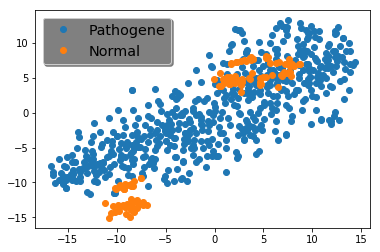

In [48]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(X_0_embedded[:,0], X_0_embedded[:,1], 'o', label='Pathogene')
ax.plot(X_1_embedded[:,0], X_1_embedded[:,1], 'o', label='Normal')

legend = ax.legend(loc='best', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('grey')

plt.show()

In [69]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(A_art,y_art)
pred = model.predict(A)

print(classification_report(y,pred))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91       568
          1       0.00      0.00      0.00       117

avg / total       0.69      0.83      0.75       685



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
